### Overview
* **Facebook's Prophet** -
    * Comprises: Trend + Seasonality + Holiday Effects + External Regressors + error
      * Trend - linear or logistic
      * Seasonality - yearly/ weekly/ daily ... multiplicative/ additive
      * Holiday effect - define the specific day, and 'window' of days around it
    * **Pros/Cons**:
      * Flexible/ customizable, dynamic events, allows regressors, *automatic*
      * Built-in cross validation and hyperparameter tuning
    * **FBProphet** package
        * [Webpage](https://facebook.github.io/prophet/), [MLM post](https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/)
---

In [1]:
# https://facebook.github.io/prophet/docs/installation.html
# !pip install pystan==2.19.1.1
# conda install -c conda-forge fbprophet
# Notes - took over 10 tries / 2 days  to get the installation to work
# Issue was kernel would die when fitting model. All kinds of issues discussed online.
# Issue was with pystan installation. Pip showed v2.19.1.1, however, Anaconda showed v2.18
# Un-installed 2.19 using pip, and reverted to 2.18 - but that threw the error that stan_backend is not
# available when fitting model
# Then updated within Anaconda Navigator which gives version options to select from. 
# Anaconda also resolved necessary updates to dependencies. 

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.display.max_columns = None

# Model
import itertools
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

# Error Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Suppress 'futurewarnings'
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

## Bike Sharing [dataset](https://www.kaggle.com/datasets/contactprad/bike-share-daily-data)

In [3]:
df = pd.read_csv('data/daily_bike_sharing.csv')
df = df.loc[:,['dteday', 'cnt', 'holiday', 'workingday','weathersit', 'temp', 'atemp', 'hum', 'windspeed']]
df.head()

,dteday,cnt,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446
1,2011-01-02,801,0,0,2,0.363478,0.353739,0.696087,0.248539
2,2011-01-03,1349,0,1,1,0.196364,0.189405,0.437273,0.248309
3,2011-01-04,1562,0,1,1,0.200000,0.212122,0.590435,0.160296
4,2011-01-05,1600,0,1,1,0.226957,0.229270,0.436957,0.186900


In [4]:
df['dteday'] = pd.to_datetime(df['dteday'], format='%Y-%m-%d')
df.dtypes

dteday        datetime64[ns]
cnt                    int64
holiday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
dtype: object

In [5]:
df = df.rename(columns={'cnt':'y', 'dteday':'ds'})  #  Prophet imposes specific names
df.head(2)

,ds,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446
1,2011-01-02,801,0,0,2,0.363478,0.353739,0.696087,0.248539


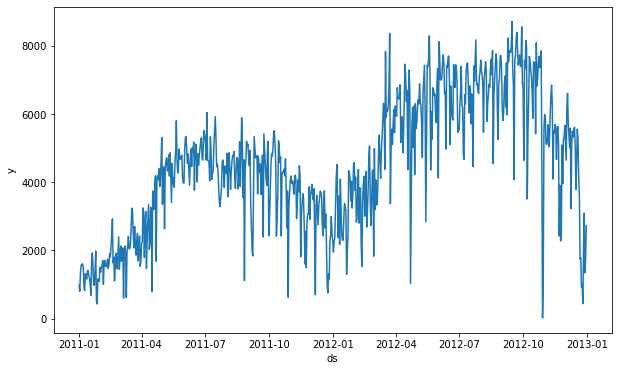

In [6]:
plt.figure(figsize = (10,6))
sns.lineplot(x = df['ds'], y=df['y']);

In [7]:
print(df[df['holiday']==1].shape)
df[df['holiday']==1][:5]

(21, 9)


,ds,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
16,2011-01-17,1000,1,0,2,0.175833,0.176771,0.537500,0.194017
51,2011-02-21,1107,1,0,2,0.303333,0.284075,0.605000,0.307846
104,2011-04-15,3126,1,0,1,0.446667,0.441913,0.671250,0.226375
149,2011-05-30,4098,1,0,1,0.733333,0.671092,0.685000,0.131225
184,2011-07-04,6043,1,0,2,0.726667,0.665417,0.637917,0.081479


In [8]:
df.query('"2011-01-12" < ds < "2011-01-20"')

,ds,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
12,2011-01-13,1406,0,1,1,0.165000,0.150883,0.470417,0.301000
13,2011-01-14,1421,0,1,1,0.160870,0.188413,0.537826,0.126548
14,2011-01-15,1248,0,0,2,0.233333,0.248112,0.498750,0.157963
15,2011-01-16,1204,0,0,1,0.231667,0.234217,0.483750,0.188433
16,2011-01-17,1000,1,0,2,0.175833,0.176771,0.537500,0.194017
17,2011-01-18,683,0,1,2,0.216667,0.232333,0.861667,0.146775
18,2011-01-19,1650,0,1,2,0.292174,0.298422,0.741739,0.208317


### >> Prepping Data

In [9]:
# pd.DataFrame with columns holiday (string) and ds (date type)
# and optionally columns lower_window and upper_window which specify a
# range of days around the date to be included as holidays.
# lower_window=-2 will include 2 days prior to the date as holidays. Also
# optionally can have a column prior_scale specifying the prior scale for that holiday.

holidays = pd.DataFrame({'holiday':'holi',
                         'ds': df[df['holiday']==1]['ds'],
                         'lower_window':-3,
                         'upper_window':1})
holidays.head()

,holiday,ds,lower_window,upper_window
16,holi,2011-01-17,-3,1
51,holi,2011-02-21,-3,1
104,holi,2011-04-15,-3,1
149,holi,2011-05-30,-3,1
184,holi,2011-07-04,-3,1


In [10]:
# Train, Test split
test_period = 31
train = df.iloc[:-test_period,:].drop(columns = 'holiday')
test  = df.iloc[-test_period:,:].drop(columns = 'holiday')
print(train.shape, test.shape)

(700, 8) (31, 8)


### >> Setting up Prophet model

In [11]:
model = Prophet(growth = 'linear',
                yearly_seasonality=True,
                weekly_seasonality=True,
                daily_seasonality=False,
                holidays=holidays,
                seasonality_mode='multiplicative',
                seasonality_prior_scale=10,
                holidays_prior_scale=10,
                changepoint_prior_scale=0.05)

In [12]:
model.add_regressor('workingday')
model.add_regressor('weathersit')
model.add_regressor('temp')
model.add_regressor('atemp')
model.add_regressor('hum')
model.add_regressor('windspeed')

In [13]:
model.fit(train)

### >> Model Forecast

In [14]:
X_df = model.make_future_dataframe(periods = len(test), freq='D')
X_df.head(2) # includes past

,ds
0,2011-01-01
1,2011-01-02


In [15]:
X_df.tail(2) # includes future

,ds
729,2012-12-30
730,2012-12-31


In [16]:
# merge external regressors
X_df = pd.concat([X_df, df.drop(columns=['ds','y'])], axis = 1)
X_df.head(2)

,ds,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,0,0,2,0.344167,0.363625,0.805833,0.160446
1,2011-01-02,0,0,2,0.363478,0.353739,0.696087,0.248539


In [17]:
forecast = model.predict(X_df)
forecast.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,atemp,atemp_lower,atemp_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,holi,holi_lower,holi_upper,holidays,holidays_lower,holidays_upper,hum,hum_lower,hum_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,temp,temp_lower,temp_upper,weathersit,weathersit_lower,weathersit_upper,weekly,weekly_lower,weekly_upper,windspeed,windspeed_lower,windspeed_upper,workingday,workingday_lower,workingday_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01,1755.647336,97.618980,1982.472597,1755.647336,1755.647336,-0.042390,-0.042390,-0.042390,-0.305608,-0.305608,-0.305608,0.0,0.0,0.0,0.0,0.0,0.0,-0.079168,-0.079168,-0.079168,-0.432391,-0.432391,-0.432391,-0.117340,-0.117340,-0.117340,-0.088643,-0.088643,-0.088643,0.142519,0.142519,0.142519,0.021932,0.021932,0.021932,0.0,0.0,0.0,-0.269302,-0.269302,-0.269302,0.0,0.0,0.0,996.521424
1,2011-01-02,1764.949591,-112.362106,1752.366786,1764.949591,1764.949591,-0.045958,-0.045958,-0.045958,-0.310561,-0.310561,-0.310561,0.0,0.0,0.0,0.0,0.0,0.0,-0.031000,-0.031000,-0.031000,-0.536096,-0.536096,-0.536096,-0.103076,-0.103076,-0.103076,-0.088643,-0.088643,-0.088643,0.035896,0.035896,0.035896,-0.041885,-0.041885,-0.041885,0.0,0.0,0.0,-0.261430,-0.261430,-0.261430,0.0,0.0,0.0,818.767659


In [18]:
preds = forecast['yhat'][-test_period:]
preds[:5]

700    4170.789459
701    3520.455744
702    5710.173690
703    5712.525322
704    5417.431442
Name: yhat, dtype: float64

In [19]:
preds.to_csv('preds_prophet.csv')

### >> Visualization

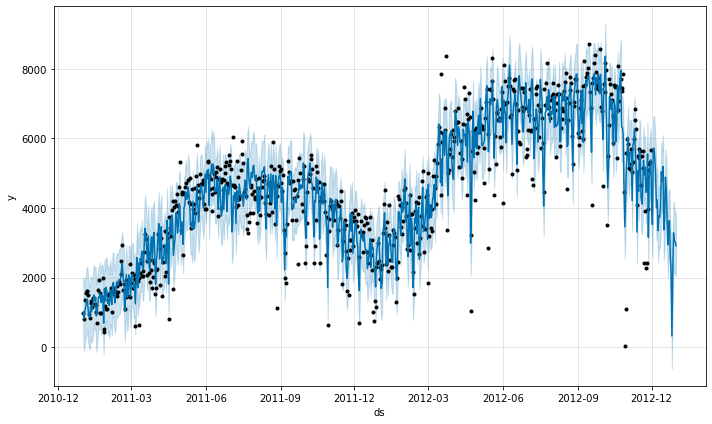

In [20]:
model.plot(forecast);

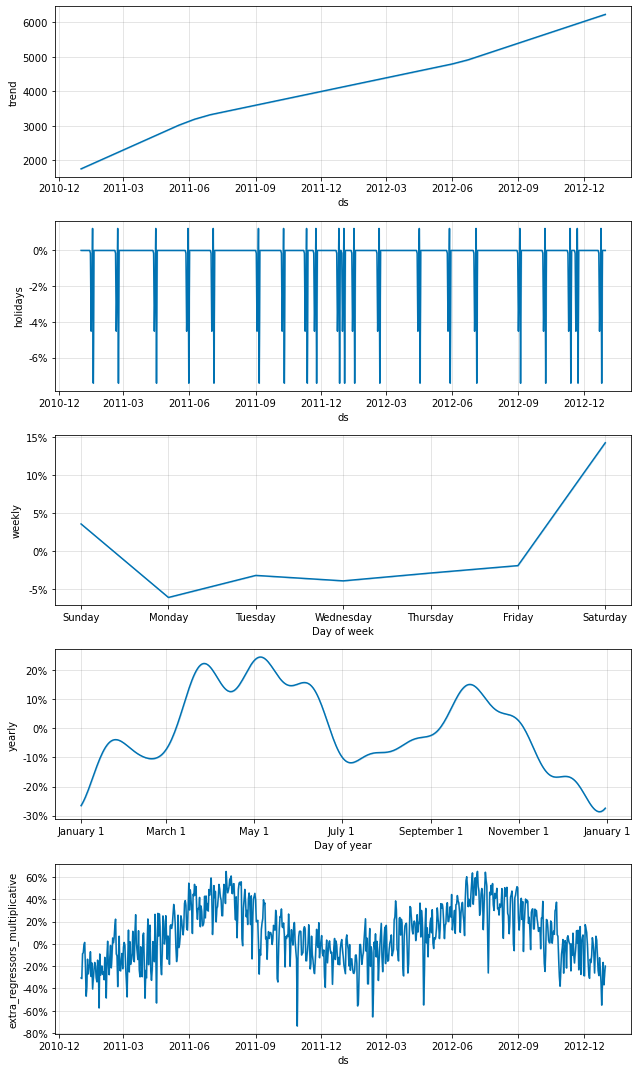

In [25]:
model.plot_components(forecast);

In [26]:
print('Average level: ', round(df['y'].mean(),0))
print('MAE:  ', mean_absolute_error(test['y'], preds).round(0))
print('RMSE: ', np.sqrt(mean_squared_error(test['y'], preds)).round(0))
print('MAPE: ', round(((test['y'] - preds)/test['y']).abs().mean()*100,2))

Average level:  4504.0
MAE:   854.0
RMSE:  1022.0
MAPE:  34.44


### >> Cross-Validation

In [27]:
df_cv = cross_validation(model, horizon='31 days',
                         initial = '540 days', # from what point should the model start CV (does a walk-forward)
                         parallel = 'processes')
df_cv.head()

INFO:fbprophet:Making 9 forecasts with cutoffs between 2012-06-28 00:00:00 and 2012-10-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000207AA0668B0>


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-06-29,8162.120137,7388.535192,8934.081181,5463,2012-06-28
1,2012-06-30,7241.952307,6465.172485,7946.462682,5687,2012-06-28
2,2012-07-01,7454.331569,6680.774942,8198.928915,5531,2012-06-28
3,2012-07-02,6802.538537,6038.097734,7644.766244,6227,2012-06-28
4,2012-07-03,7462.558604,6647.541898,8267.851043,6660,2012-06-28


In [28]:
df_cv.shape # 9*31

(279, 6)

In [29]:
print('MAE:  ', mean_absolute_error(df_cv['y'], df_cv['yhat']).round(0))
print('RMSE: ', np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat'])).round(0))
print('MAPE: ', round(((df_cv['y'] - df_cv['yhat'])/df_cv['y']).abs().mean()*100,2))

# MAPE is too large - possible larger absolute variance for smaller values

MAE:   1011.0
RMSE:  1270.0
MAPE:  126.35


### >> Parameter Tuning
* seasonality_prior_scale - strength of seasonality
* holiday_prior_scale - larges values allow the model to fit larger seasonal fluctuations
* changepoint_prior_scale - flexibility of the automatic changepoint selection

In [32]:
param_grid = {'seasonality_prior_scale':[5,10,20],
              'holiday_prior_scale':[5, 10, 20],
              'changepoint_prior_scale':[0.01, 0.05, 0.1]}

from sklearn.model_selection import ParameterGrid
grid = ParameterGrid(param_grid)

In [37]:
grid[3]

{'seasonality_prior_scale': 5,
 'holiday_prior_scale': 10,
 'changepoint_prior_scale': 0.01}

In [40]:
rmse = []
for params in grid:
    # setup model
    grid_model = Prophet(growth = 'linear',
                    yearly_seasonality=True,
                    weekly_seasonality=True,
                    daily_seasonality=False,
                    holidays=holidays,
                    seasonality_mode='multiplicative',
                    seasonality_prior_scale = params['seasonality_prior_scale'],
                    holidays_prior_scale    = params['holiday_prior_scale'],
                    changepoint_prior_scale = params['changepoint_prior_scale'])
    grid_model.add_regressor('workingday')
    grid_model.add_regressor('weathersit')
    grid_model.add_regressor('temp')
    grid_model.add_regressor('atemp')
    grid_model.add_regressor('hum')
    grid_model.add_regressor('windspeed')
    grid_model.fit(train)
    
    # cross-validation
    df_cv = cross_validation(grid_model, horizon='31 days',
                             initial = '540 days',
                             parallel = 'processes')
    
    # error
    rmse.append(np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat'])).round(0))

INFO:fbprophet:Making 9 forecasts with cutoffs between 2012-06-28 00:00:00 and 2012-10-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000207A9BDC1C0>
INFO:fbprophet:Making 9 forecasts with cutoffs between 2012-06-28 00:00:00 and 2012-10-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000207AA078E80>
INFO:fbprophet:Making 9 forecasts with cutoffs between 2012-06-28 00:00:00 and 2012-10-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000207AB77A430>
INFO:fbprophet:Making 9 forecasts with cutoffs between 2012-06-28 00:00:00 and 2012-10-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000207AB788400>
INFO:fbprophet:Making 9 forecasts with cutoffs between 2012-06-28 00:00:00 and 2012-10-30 00:00:00
INFO:fbprophet:Applying in pa

In [56]:
print(rmse)

[1079.0, 1076.0, 1078.0, 1073.0, 1075.0, 1071.0, 1083.0, 1075.0, 1079.0, 1265.0, 1261.0, 1268.0, 1264.0, 1270.0, 1273.0, 1270.0, 1271.0, 1264.0, 1301.0, 1300.0, 1303.0, 1304.0, 1305.0, 1301.0, 1301.0, 1304.0, 1302.0]


### >> Final Model

In [57]:
best_params = grid[np.argmin(rmse)]
best_params

{'seasonality_prior_scale': 20,
 'holiday_prior_scale': 10,
 'changepoint_prior_scale': 0.01}

In [58]:
final_model = Prophet(growth = 'linear',
                yearly_seasonality=True,
                weekly_seasonality=True,
                daily_seasonality=False,
                holidays=holidays,
                seasonality_mode='multiplicative',
                seasonality_prior_scale = best_params['seasonality_prior_scale'],
                holidays_prior_scale    = best_params['holiday_prior_scale'],
                changepoint_prior_scale = best_params['changepoint_prior_scale'])
final_model.add_regressor('workingday')
final_model.add_regressor('weathersit')
final_model.add_regressor('temp')
final_model.add_regressor('atemp')
final_model.add_regressor('hum')
final_model.add_regressor('windspeed')
final_model.fit(train)

In [59]:
forecast_final = model.predict(X_df)
forecast_final.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,atemp,atemp_lower,atemp_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,holi,holi_lower,holi_upper,holidays,holidays_lower,holidays_upper,hum,hum_lower,hum_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,temp,temp_lower,temp_upper,weathersit,weathersit_lower,weathersit_upper,weekly,weekly_lower,weekly_upper,windspeed,windspeed_lower,windspeed_upper,workingday,workingday_lower,workingday_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01,1755.647336,111.712493,1901.567072,1755.647336,1755.647336,-0.042390,-0.042390,-0.042390,-0.305608,-0.305608,-0.305608,0.0,0.0,0.0,0.0,0.0,0.0,-0.079168,-0.079168,-0.079168,-0.432391,-0.432391,-0.432391,-0.117340,-0.117340,-0.117340,-0.088643,-0.088643,-0.088643,0.142519,0.142519,0.142519,0.021932,0.021932,0.021932,0.0,0.0,0.0,-0.269302,-0.269302,-0.269302,0.0,0.0,0.0,996.521424
1,2011-01-02,1764.949591,-14.042687,1794.649393,1764.949591,1764.949591,-0.045958,-0.045958,-0.045958,-0.310561,-0.310561,-0.310561,0.0,0.0,0.0,0.0,0.0,0.0,-0.031000,-0.031000,-0.031000,-0.536096,-0.536096,-0.536096,-0.103076,-0.103076,-0.103076,-0.088643,-0.088643,-0.088643,0.035896,0.035896,0.035896,-0.041885,-0.041885,-0.041885,0.0,0.0,0.0,-0.261430,-0.261430,-0.261430,0.0,0.0,0.0,818.767659


In [89]:
preds_tuned = pd.Series(forecast_final['yhat'][-test_period:].values, index = test['ds'].values)
preds_tuned.to_csv('preds_prophet_tuned.csv')

In [90]:
preds_tuned[:5]

2012-12-01    4170.789459
2012-12-02    3520.455744
2012-12-03    5710.173690
2012-12-04    5712.525322
2012-12-05    5417.431442
dtype: float64

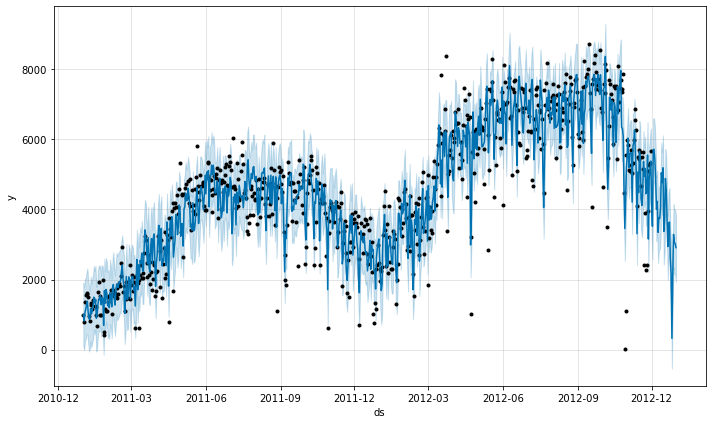

In [62]:
model.plot(forecast_final);

In [91]:
train['y']

0       985
1       801
2      1349
3      1562
4      1600
       ... 
695    5087
696    3959
697    5260
698    5323
699    5668
Name: y, Length: 700, dtype: int64

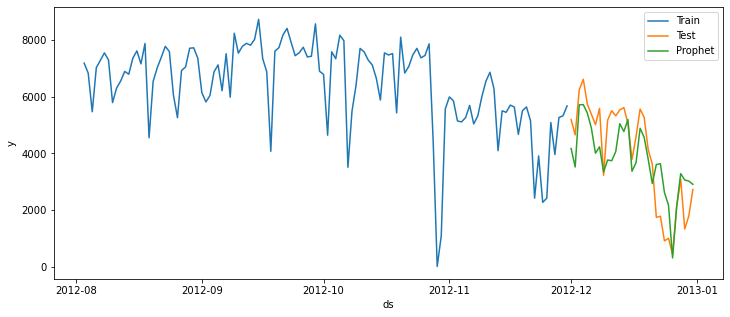

In [100]:
plt.figure(figsize = (12,5))
sns.lineplot(data = train[-120:], x='ds', y='y', label='Train')
sns.lineplot(data = test, x='ds', y='y', label='Test' )
sns.lineplot(x = preds_tuned.index, y = preds_tuned.values, label='Prophet')
plt.legend(loc='best');